In [5]:
import pandas as pd
import numpy as np

PATH_OPS  = r"C:\Users\seonu\Documents\soundscape-data\EDA\dataset\한국환경공단_소음진동측정망 운영정보_20241231.csv"
PATH_ENV  = r"C:\Users\seonu\Documents\soundscape-data\EDA\dataset\한국환경공단_환경소음 측정망 정보_20241231.csv"
PATH_SITE = r"C:\Users\seonu\Documents\soundscape-data\EDA\dataset\한국환경공단_환경소음 측정망 지점 정보_20241231.csv"


def read_csv_safely(path):
    for enc in ["utf-8-sig", "cp949", "euc-kr", "utf-8"]:
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception:
            pass
    return pd.read_csv(path)

ops  = read_csv_safely(PATH_OPS)
env  = read_csv_safely(PATH_ENV)
site = read_csv_safely(PATH_SITE)


# 운영정보 표준화

ops2 = ops.copy()
ops2["측정일"] = pd.to_datetime(ops2["측정일"], errors="coerce")
ops2["소음도"] = pd.to_numeric(ops2["소음도"], errors="coerce")

ops2["join_key"] = (
    ops2["도시"].astype(str).str.strip()
    + "|"
    + ops2["측정지점"].astype(str).str.strip()
)


# 지점정보 표준화

site2 = site.copy()


site2["join_key_by_name"] = site2["측정지점"].astype(str).str.strip()
ops2["join_key_by_name"]  = ops2["측정지점"].astype(str).str.strip()


site2["위도"] = pd.to_numeric(site2["위도"], errors="coerce")
site2["경도"] = pd.to_numeric(site2["경도"], errors="coerce")


# 환경소음 측정망 정보 표준화

env2 = env.copy()
env2["주간평균"] = pd.to_numeric(env2["주간평균"], errors="coerce")
env2["야간평균"] = pd.to_numeric(env2["야간평균"], errors="coerce")

env2["join_key"] = (
    env2["도시"].astype(str).str.strip()
    + "|"
    + env2["측정지점"].astype(str).str.strip()
)


merged = ops2.merge(
    site2[
        ["join_key_by_name", "주소", "지역", "용도구분", "위도", "경도"]
    ].drop_duplicates("join_key_by_name"),
    on="join_key_by_name",
    how="left"
)

merged = merged.merge(
    env2[
        ["join_key", "측정연도", "분기", "주간평균", "야간평균"]
    ].drop_duplicates(["join_key", "측정연도", "분기"]),
    on="join_key",
    how="left"
)


merged["용도구분_std"] = (
    merged.get("용도구분_y")
    .fillna(merged.get("용도구분_x"))
)

merged["지역_std"] = (
    merged.get("지역_y")
    .fillna(merged.get("지역_x"))
)


# location7 매핑 

def map_location7(row):
    addr = str(row.get("주소", ""))
    usage = str(row.get("용도구분_std", ""))
    area = str(row.get("지역_std", ""))

    # 이동/교통
    if area == "도로":
        return "moving"

    # 공원/야외
    if "공원" in addr:
        return "park"

    # 주거
    if usage == "전용주거지역":
        return "home"

    # 도서관/학습
    if usage == "학교지역":
        return "library"

    # 헬스장
    if any(k in addr for k in ["헬스", "피트니스", "체육관"]):
        return "gym"

    # 상업/카페
    if usage == "상업지역" or "편의점" in addr or "카페" in addr:
        return "cafe"

    # 기본값
    return "co-working"


merged["location7"] = merged.apply(map_location7, axis=1)


# noise_band

bins = [0, 35, 50, 65, 80, 200]
labels = ["0-35", "36-50", "51-65", "66-80", "81+"]
merged["noise_band"] = pd.cut(
    merged["소음도"], bins=bins, labels=labels, include_lowest=True
)


# location별 평균 dBA

eda_loc = (
    merged.dropna(subset=["소음도"])
    .groupby("location7")["소음도"]
    .agg(
        count="count",
        mean="mean",
        median="median",
        std="std",
        min="min",
        max="max",
    )
    .sort_values("mean")
)

print("\n[EDA1] location7별 평균 dBA")
print(eda_loc)


# 변동성 분석

def iqr(x):
    x = pd.Series(x).dropna()
    return np.percentile(x, 75) - np.percentile(x, 25) if len(x) else np.nan

station_stats = (
    merged.dropna(subset=["소음도"])
    .groupby(["도시", "측정지점", "location7"])["소음도"]
    .agg(
        count="count",
        mean="mean",
        std="std",
        iqr=iqr,
        p95=lambda x: np.percentile(pd.Series(x).dropna(), 95),
        peak="max",
    )
    .reset_index()
)

eda_var = (
    station_stats.groupby("location7")[["std", "iqr", "p95", "peak"]]
    .agg(["mean", "median"])
)

print("\n[EDA-A] location7별 변동성 요약")
print(eda_var)


# noise_band 분포

band_dist = (
    merged["noise_band"]
    .value_counts(dropna=False)
    .rename_axis("noise_band")
    .reset_index(name="count")
)

print("\n[Noise Band Distribution]")
print(band_dist)


eda_loc.to_csv(r"C:\Users\seonu\Documents\soundscape-data\EDA\result\EDA_location_mean.csv", encoding="utf-8-sig")
station_stats.to_csv(r"C:\Users\seonu\Documents\soundscape-data\EDA\result\EDA_station_variability.csv", encoding="utf-8-sig", index=False)
band_dist.to_csv(r"C:\Users\seonu\Documents\soundscape-data\EDA\result\EDA_noise_band_dist.csv", encoding="utf-8-sig", index=False)

print("\n EDA 결과 저장 완료")



[EDA1] location7별 평균 dBA
            count       mean  median       std    min    max
location7                                                   
home         1280  53.365867   52.60  3.866411  45.24  68.17
library      3116  57.418312   57.49  5.429776  44.17  77.32
co-working  44168  57.499285   56.42  5.091715  43.33  94.94
cafe         6052  59.544394   58.26  4.797287  48.22  92.13
moving      93953  66.961881   67.54  4.505028  31.78  83.70

[EDA-A] location7별 변동성 요약
                 std                 iqr                 p95           \
                mean    median      mean   median       mean   median   
location7                                                               
cafe        2.343071  1.795424  1.847368  1.66000  64.798526  62.6320   
co-working  2.844041  2.447417  2.563327  2.23000  63.240271  62.0050   
home        3.035350  3.037328  2.516250  2.64125  60.617750  60.4640   
library     3.204065  2.838900  2.835000  2.67750  64.300682  63.2325   
moving   

1) 위치별 dBA 분포(박스플롯) + noise band 라인

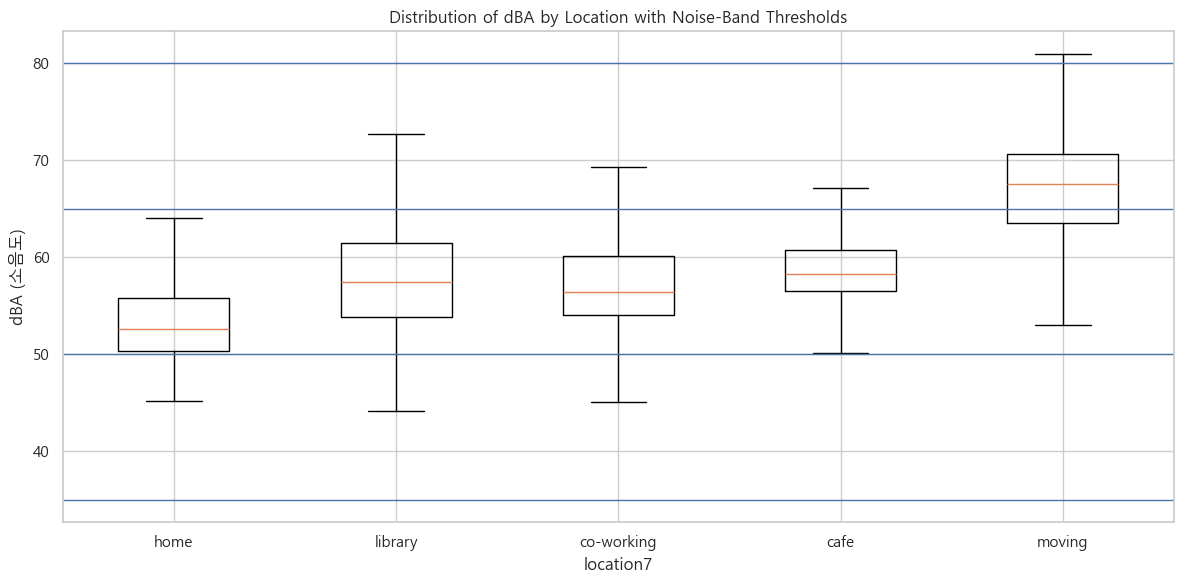

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

dfv = merged.dropna(subset=["소음도"]).copy()

loc_order = ["home", "library", "co-working", "cafe", "moving", "gym", "park"]
loc_order = [x for x in loc_order if x in dfv["location7"].unique()]

data_by_loc = [dfv.loc[dfv["location7"] == loc, "소음도"].values for loc in loc_order]

plt.figure(figsize=(12, 6))
plt.boxplot(
    data_by_loc,
    tick_labels=loc_order,   
    showfliers=False
)

for y in [35, 50, 65, 80]:
    plt.axhline(y, linewidth=1)

plt.title("Distribution of dBA by Location with Noise-Band Thresholds")
plt.xlabel("location7")
plt.ylabel("dBA (소음도)")
plt.tight_layout()
plt.show()


2) 측정지점 단위 평균 dBA vs 변동성(std) 산점도 (+ band 영역)

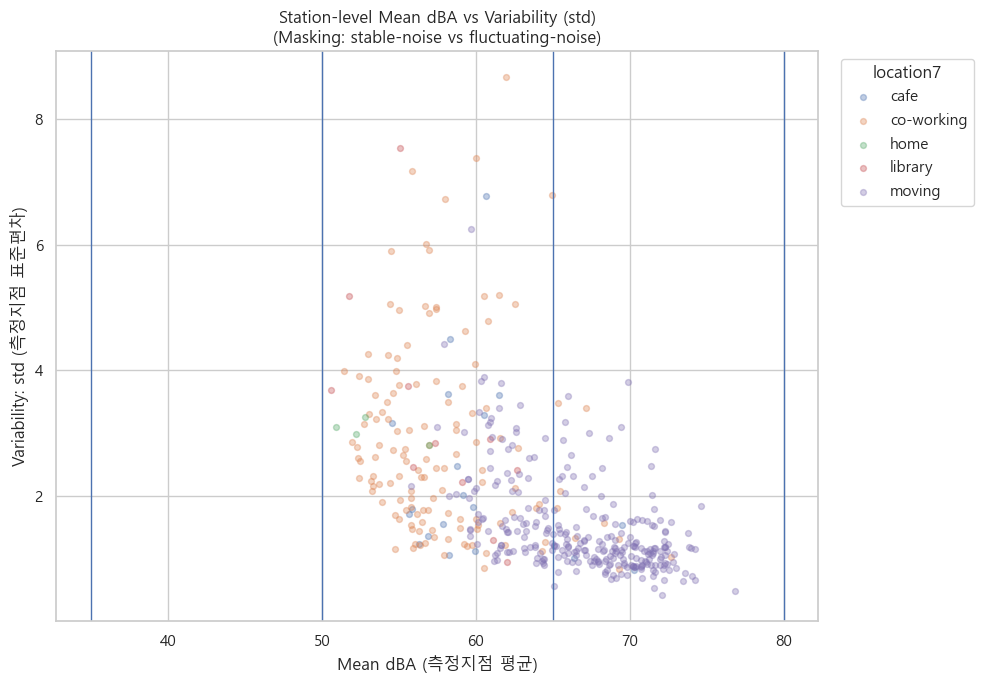

In [9]:
import numpy as np
import matplotlib.pyplot as plt

s = station_stats.dropna(subset=["mean", "std"]).copy()

plt.figure(figsize=(10, 7))

for loc in sorted(s["location7"].unique()):
    sub = s[s["location7"] == loc]
    plt.scatter(sub["mean"], sub["std"], alpha=0.35, s=18, label=loc)

for x in [35, 50, 65, 80]:
    plt.axvline(x, linewidth=1)

plt.title("Station-level Mean dBA vs Variability (std)\n(Masking: stable-noise vs fluctuating-noise)")
plt.xlabel("Mean dBA (측정지점 평균)")
plt.ylabel("Variability: std (측정지점 표준편차)")
plt.legend(title="location7", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


>평균이 높아도(std 낮으면) → “지속적 소음(백색소음형)”
>
>평균이 비슷해도(std 높으면) → “이벤트성 소음(주의 분산형)”
>
>moving이 평균 높고 std 낮은 쪽에 몰림 -> 마스킹 개념을 지지

3) location별 noise_band 구성비(스택 바)

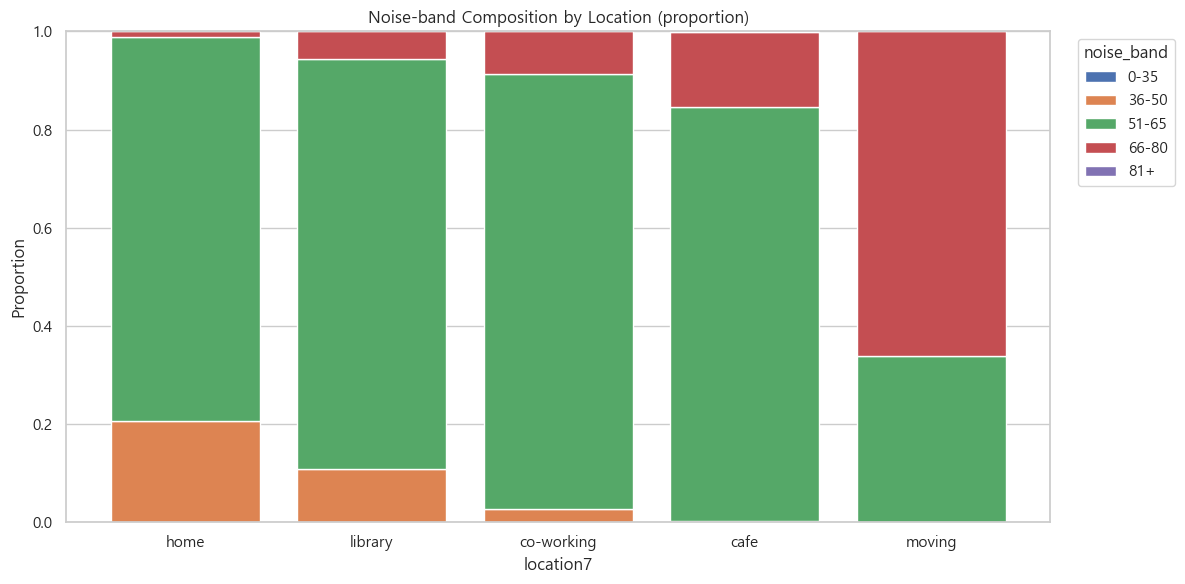

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

dfb = merged.dropna(subset=["소음도"]).copy()
bins = [0, 35, 50, 65, 80, 200]
labels = ["0-35", "36-50", "51-65", "66-80", "81+"]
dfb["noise_band"] = pd.cut(dfb["소음도"], bins=bins, labels=labels, include_lowest=True)

ct = pd.crosstab(dfb["location7"], dfb["noise_band"], normalize="index")
ct = ct.reindex(index=loc_order).dropna(how="all")

plt.figure(figsize=(12, 6))
bottom = np.zeros(len(ct))

for band in ct.columns:
    vals = ct[band].values
    plt.bar(ct.index, vals, bottom=bottom, label=str(band))
    bottom += vals

plt.title("Noise-band Composition by Location (proportion)")
plt.xlabel("location7")
plt.ylabel("Proportion")
plt.legend(title="noise_band", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


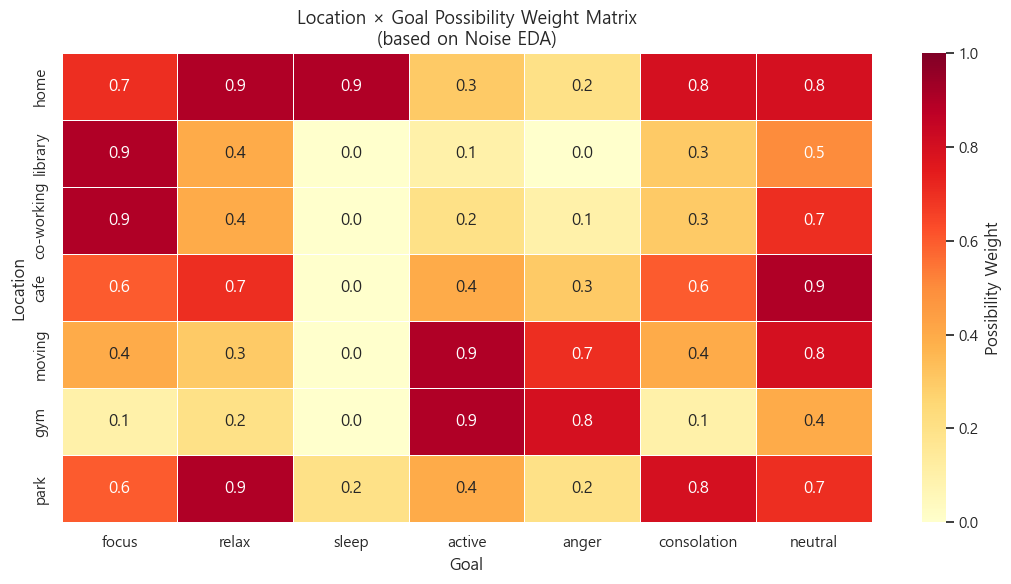

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = {
    "focus":        [0.7, 0.9, 0.9, 0.6, 0.4, 0.1, 0.6],
    "relax":        [0.9, 0.4, 0.4, 0.7, 0.3, 0.2, 0.9],
    "sleep":        [0.9, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2],
    "active":       [0.3, 0.1, 0.2, 0.4, 0.9, 0.9, 0.4],
    "anger":        [0.2, 0.0, 0.1, 0.3, 0.7, 0.8, 0.2],
    "consolation":  [0.8, 0.3, 0.3, 0.6, 0.4, 0.1, 0.8],
    "neutral":      [0.8, 0.5, 0.7, 0.9, 0.8, 0.4, 0.7],
}

index = ["home", "library", "co-working", "cafe", "moving", "gym", "park"]

df = pd.DataFrame(data, index=index)

plt.figure(figsize=(11, 6))

sns.heatmap(
    df,
    annot=True,         
    fmt=".1f",
    cmap="YlOrRd",       
    vmin=0,
    vmax=1,
    linewidths=0.5,
    cbar_kws={"label": "Possibility Weight"}
)

plt.title("Location × Goal Possibility Weight Matrix\n(based on Noise EDA)", fontsize=13)
plt.xlabel("Goal")
plt.ylabel("Location")
plt.tight_layout()
plt.show()
